In [1]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from IPython.display import Audio

In [2]:
#file = "string_1.wav"
file = "truck.wav"
sample_rate, signal = wavfile.read(file)
#since the signal is stereo, we will only use one channel
signal = signal[:, 0]
print(sample_rate)

48000


In [3]:
scaling_factor = 1
attenuation = 0.5
seconds_to_delay = 0.5
frame_delay = int(seconds_to_delay * sample_rate)

In [4]:
def iir_delay_filter(signal, scaling_factor, attenuation, time_delay):
    """	
    s[t] = scaling_factor * e[t] + attenuation * s[t - time_delay]
    """
    output = np.zeros(len(signal))
    for i, frame in enumerate(signal):
        if i < time_delay:
            output[i] = scaling_factor * frame
        else:
            output[i] = scaling_factor * frame + attenuation * output[i - time_delay]
    return output



In [5]:
dirac = np.zeros(frame_delay+1)
dirac[0] = 1

filtered_dirac = iir_delay_filter(dirac, scaling_factor, attenuation, frame_delay)

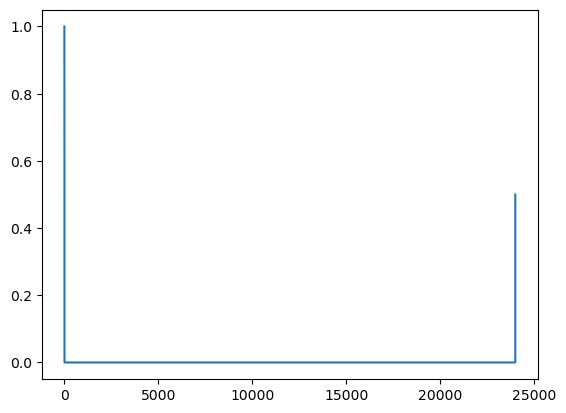

In [6]:
plt.plot(filtered_dirac)

The filter response looks identical to the FIR convolution. However, if we zoom out...

In [7]:
dirac = np.zeros(len(signal))
dirac[0] = 1

filtered_dirac = iir_delay_filter(dirac, scaling_factor, attenuation, frame_delay)

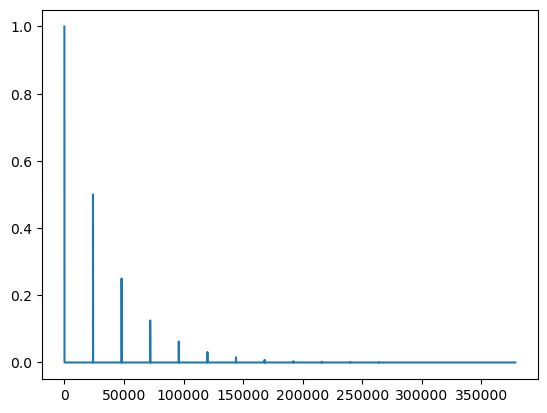

In [8]:
plt.plot(filtered_dirac)

The IIR response will fade out, with the effect getting infinitely small over time. As such, to be able to properly apply the IIR implementation, we would need a impulse response convolution of the same size as the input signal.

In [9]:
def impulse_response_convolution(signal, impulse_response):
    """
    Given a signal, convolve it with the impulse response.
    """
    signal_padded = np.pad(signal, (len(impulse_response)-1, 0), 'constant', constant_values=(0, 0))
    new_signal = np.convolve(signal_padded, impulse_response, mode='valid')
    return new_signal

In [10]:
delayed_signal_filter = iir_delay_filter(signal, scaling_factor, attenuation, frame_delay)

In [11]:
delayed_signal_impulse_response = impulse_response_convolution(signal, filtered_dirac)

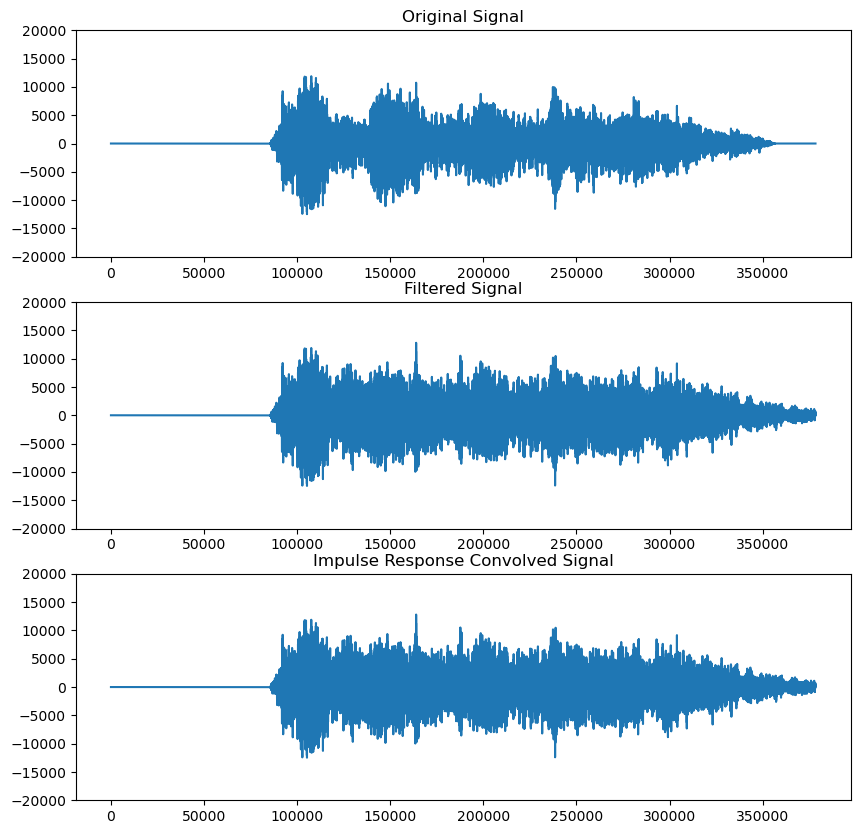

In [12]:
#plot side by side
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
plt.setp(axs, ylim=(-20000, 20000))
axs[0].plot(signal)
axs[0].set_title('Original Signal')
axs[1].plot(delayed_signal_filter)
axs[1].set_title('Filtered Signal')
axs[2].plot(delayed_signal_impulse_response)
axs[2].set_title('Impulse Response Convolved Signal')
plt.ylim(-20000, 20000)
plt.show()

In [13]:
#play the signal
Audio(signal, rate=sample_rate)

In [14]:
Audio(delayed_signal_impulse_response, rate=sample_rate)

## Stability

With the IIR delay filter, the signal will slowly fade out, but keep going infinitely. 

Following the rules of a geometric series, the IIR signal will be stable if the input is finite and the scaling factor is below 1, converging to:

 $ ||signal||_1 = \sum_t^n\sum_{r}^k signal[t-delay] = signal[t] * attenuation^r $, for attenuation \< 1.

If the scaling factor is 1, the signal will remain constant once the input ends; and if the scaling factor is above 1, it will get louder and louder. Nonetheless, in these cases:

$||signal||_1 = + \inf $, and thus, the signal is not stable.

## Difference from FIR

Opposed to FIR, which is a stable finite filter, the IIR filter will cause a neverending echo effect, which will end up increasing in intensity for scaling factors above 1.